# 初期化

## import

In [34]:
from control import matlab
from matplotlib import pyplot as plt
import numpy as np
from scipy import linalg

## 共通パラメータ

### 可変部分

In [35]:
ms = 1500      # kg    車体重量p
ms_max = 2000  # kg    msの上限値
ms_min = 1100  # kg    msの下限値
muf = 20       # kg    前輪重量
mur = 20       # kg    後輪重量

ksf = 14000    # N/m   前輪-車体間のバネ係数
ksr = 15000    # N/m   後輪-車体間のバネ係数
ktf = 16000    # N/m   路面-前輪間のバネ係数
ktr = 19000    # N/m   路面-後輪間のバネ係数

csf = 1800     # N/m/s 前輪のダンパ係数
csr = 1900     # N/m/s 後輪のダンパ係数

ls = 4         # m     車体全長
lsf = 2        # m     重心から前軸までの距離
lsr = 2        # m     重心から後ろ軸までの距離

v = 30         # km/h  車体速度

# 重みパラメータ
q = np.array(
    [1, 1, 100, 1, 1, 1, 1, 1]
)
r = np.array(
    [1, 1]
)
r = r*10**-8

ms = 11000      # kg    車体重量p
ms_max = 2000  # kg    msの上限値
ms_min = 1100  # kg    msの下限値
muf = ms/2       # kg    前輪重量
mur = ms/2       # kg    後輪重量

ksf = 28000    # N/m   前輪-車体間のバネ係数
ksr = 25000    # N/m   後輪-車体間のバネ係数
ktf = 16000    # N/m   路面-前輪間のバネ係数
ktr = 25000    # N/m   路面-後輪間のバネ係数

csf = 2500     # N/m/s 前輪のダンパ係数
csr = 2000     # N/m/s 後輪のダンパ係数

lsf = 4.393        # m     重心から前軸までの距離
lsr = 2.162        # m     重心から後ろ軸までの距離
ls = lsf+lsr         # m     車体全長

v = 30         # km/h  車体速度

# 重みパラメータ
q = np.array(
    [1, 1, 100, 1, 1, 1, 1, 1]
)
r = np.array(
    [1, 1]
)

### パラメータ計算

In [36]:
# パラメータ計算
Is = ms*ls*ls/12  # ばね上慣性モーメント
lfr = lsf+lsr  # 前輪から後輪までの距離
vsec = v*1000/3600  # m/s 秒速
tfr = lfr/vsec  # 前輪と後輪が同じ地点を通るまでにかかる時間

# 重み行列
Q = np.diag(q)
R = np.diag(r)

# 状態方程式
Ap = np.zeros((8, 8))
Ap[0] = np.array([0, 1, 0, 0, 0, 0, 0, 0])
Ap[2] = np.array([0, 0, 0, 1, 0, 0, 0, 0])
Ap[4] = np.array([0, 0, 0, 0, 0, 1, 0, 0])
Ap[6] = np.array([0, 0, 0, 0, 0, 0, 0, 1])

Ap[1] = np.array([-(ksf+ksr), -(csf+csr), ksf*lsf-ksr*lsr,
                  csf*lsf-csr*lsr, ksf, csf, ksr, csr])/ms
Ap[3] = np.array([lsf*ksf-lsr*ksr, lsf*csf-lsr*csr, -(lsf*lsf*ksf+lsr*lsr*ksr), -(lsf*lsf*csf+lsr*lsr*csr),
                  -lsf*ksf, -lsf*csf, lsr*ksr, lsr*csr])/Is
Ap[5] = np.array([ksf, csf, -lsf*ksf, -lsf*csf, -(ksf+ktf), -csf, 0, 0])/muf
Ap[7] = np.array([ksr, csr, lsr*ksr, lsr*csr, 0, 0, -(ksr+ktr), -csr])/mur

Bp1 = np.array(
    [
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [ktf/muf, 0],
        [0, 0],
        [0, ktr/mur]
    ]
)

Bp2 = np.array(
    [
        [0, 0],
        [1/ms, 1/ms],
        [0, 0],
        [-lsf/Is, lsr/Is],
        [0, 0],
        [-1/muf, 0],
        [0, 0],
        [0, -1/mur]
    ]
)

Cp =  np.eye(8)

Dp = np.zeros((8, 2))

# クラス

In [68]:
# import
from control import matlab
from matplotlib import pyplot as plt
import numpy as np
from scipy import linalg


class pycontrol:
    """
    discrete control simulation module
    """

    def __init__(self, A, B1, B2, C, D, Ts=0.01):

        self.sys = matlab.ss(A, B1, C, D)
        self.sysd = matlab.c2d(self.sys, Ts)
        self.sys2 = matlab.ss(A, B2, C, D)
        self.sysd2 = matlab.c2d(self.sys2, Ts)
        self.Ts = Ts

    def erLqr(self, phi, G, Q, R):
        P = linalg.solve_discrete_are(phi, G, Q, R)
        K = linalg.inv(R+G.T.dot(P).dot(G)).dot(G.T).dot(P).phi
        # K = linalg.inv(R).dot(B.T).dot(P)
        E = 0

        return P, K, E

    def lqr(self, Q, R):
        '''
        最適レギュレータ計算
        離散系
        '''
        A = self.sysd2.A
        B = self.sysd2.B

        P = linalg.solve_discrete_are(A, B, Q, R)
        K = linalg.inv(R+B.T.dot(P).dot(B)).dot(B.T).dot(P).A
        # K = linalg.inv(R).dot(B.T).dot(P)
        E = linalg.eigvals(A - B.dot(K))

        return P, K, E

    def errorSystem(self):
        i8 = np.ones((8, 8))

        phi = np.array(
            [
                [np.ones((8, 8)), -np.ones((8, 8)).dot(self.sysd.A)],
                [np.zeros((8, 8)), self.sysd.A]
            ]
        )
        phi = np.vstack((np.hstack((np.ones((8, 8)), -np.ones((8, 8)).dot(self.sysd.A))),
                         np.hstack((np.zeros((8, 8)), self.sysd.A))))
        G = np.vstack((-np.ones((8,8)).dot(self.sysd2.B), self.sysd2.B))
        Gd = np.vstack((-np.ones((8,8)).dot(self.sysd.B), self.sysd.B))
        return phi, G, Gd

    def setSusParam(self, lfr, vsec):
        self.v = vsec
        self.lfr = lfr

    def disturbance(self, func, d):
        return np.array([[func(d+self.lfr)], [func(d)]])

    def passiveSus(self, func, t1):
        t = np.arange(0, t1, self.Ts)
        x = np.zeros((8, 1))
        y = np.zeros((t.size, 8, 1))
        d = 0
        for i in range(t.size):
            d += self.v*self.Ts
            dx = np.dot(self.sysd.A, x) + \
                np.dot(self.sysd.B, self.disturbance(func, d))
            y[i] = x
            x = dx
        return t, y

    def feedbackSus(self, K, func, t1):
        t = np.arange(0, t1, self.Ts)
        x = np.zeros((8, 1))
        y = np.zeros((t.size, 8, 1))
        d = 0
        for i in range(t.size):
            d += self.v*self.Ts
            u = -np.dot(K, x)
            dx = np.dot(self.sysd.A, x) + \
                np.dot(self.sysd.B, self.disturbance(func, d)) + \
                np.dot(self.sysd2.B, u)
            y[i] = x
            x = dx
            # print(u)
        return t, y

    def erFeedbackSus(self, K, func, t1):
        t = np.arange(0, t1, self.Ts)
        x = np.zeros((8, 1))
        y = np.zeros((t.size, 8, 1))
        d = 0
        for i in range(t.size):
            d += self.v*self.Ts
            u = -np.dot(K, x)
            dx = np.dot(self.sysd.A, x) + \
                np.dot(self.sysd.B, self.disturbance(func, d)) + \
                np.dot(self.sysd2.B, u)
            y[i] = x
            x = dx
            # print(u)
        return t, y

    def previewSus(self, K, func, t1):
        t = np.arange(0, t1, self.Ts)
        x = np.zeros((8, 1))
        y = np.zeros((t.size, 8, 1))
        u = np.zeros((2, 1))
        d = 0
        for i in range(t.size):
            d += self.v*self.Ts
            dx = dx = np.dot(self.sysd.A, x) + \
                np.dot(self.sysd.B, self.disturbance(func, d)) + \
                np.dot(self.sysd2.B, u)
            y[i] = x
            x = dx

        return t, y

# 処理部

## テスト用外乱関数

In [38]:
def step(x):
    if x < 30:
        return 0
    else:
        return 0.05

def sin1(x):
    if x < 3:
        return 0
    else:
        return 0.5*np.sin((x-3)/10)

# テスト外乱切り替え用
def dist():
    return step

## パッシブサスペンション

In [27]:
sys1 = pycontrol(Ap, Bp1, Bp2, Cp, Dp)
sys1.setSusParam(lfr, vsec)
t, y1 = sys1.passiveSus(dist(), 15)

## フィードバック制御

### デジタル最適レギュレータ

In [39]:
sys2 = pycontrol(Ap, Bp1, Bp2, Cp, Dp)
sys2.setSusParam(lfr, vsec)
P, K, E = sys2.lqr(Q, R)
t, y2 = sys2.feedbackSus(K, dist(), 15)

### エラーシステムありデジタル最適レギュレータ

In [69]:
sys3 = pycontrol(Ap, Bp1, Bp2, Cp, Dp)
sys3.setSusParam(lfr, vsec)
phi, G, Gd = sys3.errorSystem()
P, K, E = sys3.erLqr(phi, G, Q, R)

ValueError: Matrix a and q should have the same shape.

## 予見制御

In [21]:
sys4 = pycontrol(Ap, Bp1, Bp2, Cp, Dp)
sys2.setSusParam(lfr, vsec)
P, K, E = sys2.lqr(Q, R)

# 外乱速度変化

In [123]:
Ts = 0.01
t = np.arange(0, 30, Ts)

def step(x):
    if x < 30:
        return 0
    else:
        return 0.05
    
def sin1(x):
    return np.sin(x*Ts)

## v = 10

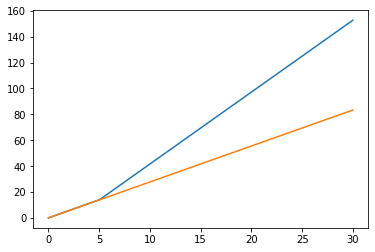

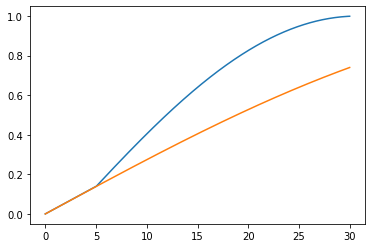

In [124]:
v1 = 10
vsec1 = v1*1000/3600
vsec2 = vsec1
d1 = np.zeros((t.size))
d2 = np.zeros((t.size))
w1 = np.zeros((t.size))
w2 = np.zeros((t.size))

d1[0] = 0
w1[0] = 0
d2[0] = 0
w2[0] = 0
for i in range(1, t.size):
        d1[i] = d1[i-1] + vsec1*Ts
        w1[i] = sin1(d1[i])
        if i > 500:
            v1 = 20
            vsec1 = v1*1000/3600
        d2[i] = d2[i-1] + vsec2*Ts
        w2[i] = sin1(d2[i])

plt.figure()
plt.plot(t, d1)
plt.plot(t, d2)

plt.figure()
plt.plot(t, w1)
plt.plot(t, w2)


# グラフ

## 動作

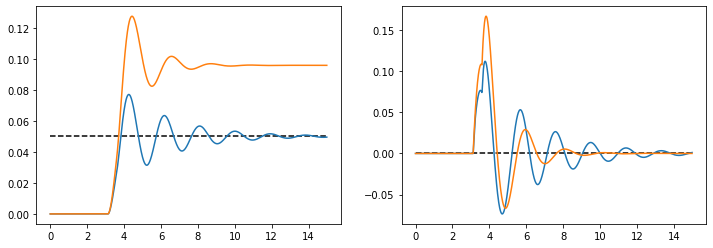

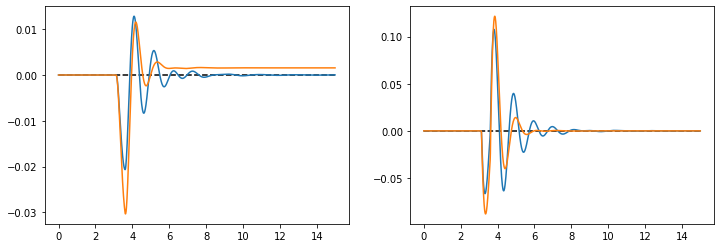

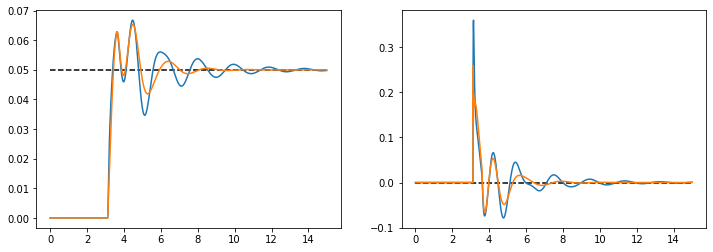

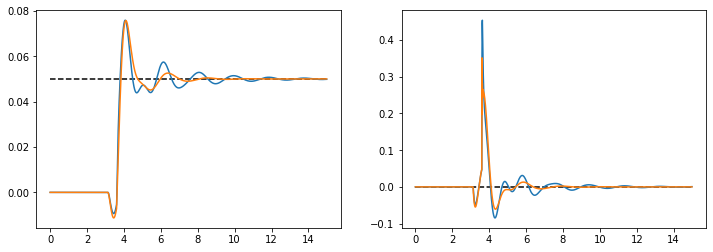

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, y1[:, 0])
plt.plot(t, y2[:, 0])
plt.hlines([0.05], 0, 15, linestyles='dashed') 
plt.subplot(1, 2, 2)
plt.plot(t, y1[:, 1])
plt.plot(t, y2[:, 1])
plt.hlines([0.], 0, 15, linestyles='dashed') 

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, y1[:, 2])
plt.plot(t, y2[:, 2])
plt.hlines([0], 0, 15, linestyles='dashed') 
plt.subplot(1, 2, 2)
plt.plot(t, y1[:, 3])
plt.plot(t, y2[:, 3])
plt.hlines([0], 0, 15, linestyles='dashed') 

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, y1[:, 4])
plt.plot(t, y2[:, 4])
plt.hlines([0.05], 0, 15, linestyles='dashed') 
plt.subplot(1, 2, 2)
plt.plot(t, y1[:, 5])
plt.plot(t, y2[:, 5])
plt.hlines([0], 0, 15, linestyles='dashed') 

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, y1[:, 6])
plt.plot(t, y2[:, 6])
plt.hlines([0.05], 0, 15, linestyles='dashed') 
plt.subplot(1, 2, 2)
plt.plot(t, y1[:, 7])
plt.plot(t, y2[:, 7])
plt.hlines([0], 0, 15, linestyles='dashed') 

## 差分(パッシブ基準)

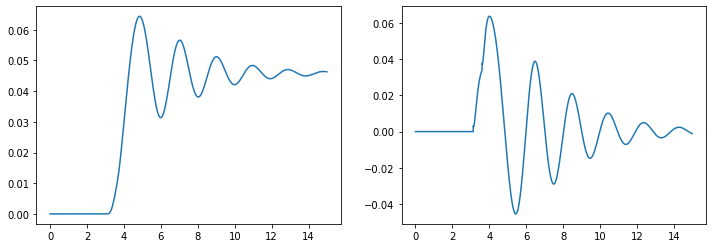

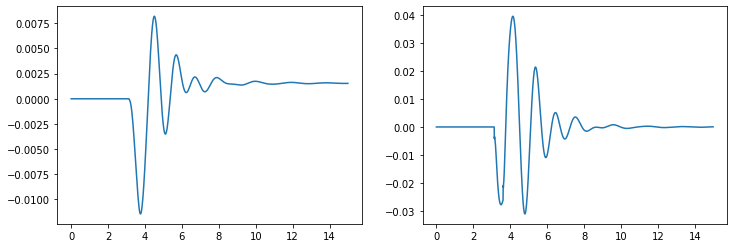

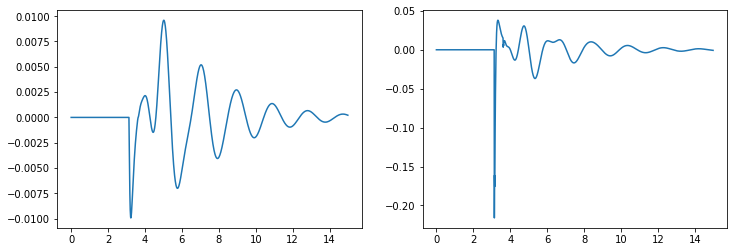

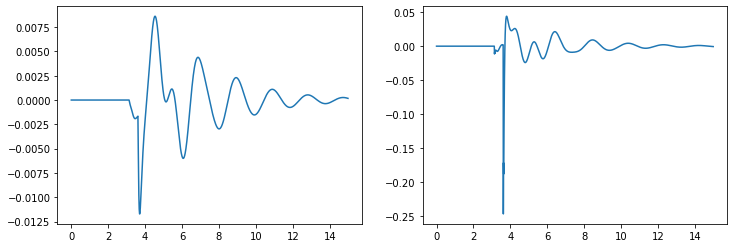

In [30]:
dy1 = y2-y1
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, dy1[:, 0])
plt.subplot(1, 2, 2)
plt.plot(t, dy1[:, 1])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, dy1[:, 2])
plt.subplot(1, 2, 2)
plt.plot(t, dy1[:, 3])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, dy1[:, 4])
plt.subplot(1, 2, 2)
plt.plot(t, dy1[:, 5])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t, dy1[:, 6])
plt.subplot(1, 2, 2)
plt.plot(t, dy1[:, 7])

In [31]:
Ap

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.93333333e+01, -2.46666667e+00, -1.33333333e+00,
        -1.33333333e-01,  9.33333333e+00,  1.20000000e+00,
         1.00000000e+01,  1.26666667e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.00000000e+00, -1.00000000e-01, -5.80000000e+01,
        -7.40000000e+00, -1.40000000e+01, -1.80000000e+00,
         1.50000000e+01,  1.90000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 7.00000000e+02,  9.00000000e+01, -1.40000000e+03,
        -1.80000000e+02, -1.50000000e+03, -9.00000000e+01,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.000000

In [32]:
Bp2

array([[ 0.        ,  0.        ],
       [ 0.00066667,  0.00066667],
       [ 0.        ,  0.        ],
       [-0.001     ,  0.001     ],
       [ 0.        ,  0.        ],
       [-0.05      ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        , -0.05      ]])

In [33]:
K

array([[  3653.73429488,   3233.72404065, -18287.37668378,
         -6357.94910902, -25697.29324708,  -2586.39057926,
          7304.95857431,    -98.51735153],
       [  3282.61960007,   2908.38485796,  21057.05227381,
          6962.30833817,   7411.69489838,   -114.09406674,
        -29032.54812624,  -2621.38776974]])